# Notebook Version 2

I made a condensed, and more flexible notebook from out initial. It contains the same processing, but not ass much intermittent reporting making navigation easier. One can of course add code where additional summary reports or graphics is needed. In addition, if the functions generating these reports are in a separate file, this notebook can stay condensed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency



In [2]:
from helpers import outliers_IQR, outliers_z_score, outliers_min_max, handle_outliers, fix_obesity

In [3]:
diabetes = pd.read_csv('diabetes.csv')

binary_features = ['Obesity', 'TCep', 'Polydipsia', 'Sudden Weight Loss', 'Weakness',
                   'Polyphagia', 'Genital Thrush', 'Visual Blurring', 'Itching',
                   'Irritability', 'Delayed Healing', 'Partial Paresis', 'Muscle Stiffness', 'Alopecia']
cat_features = ['Race',	'Occupation',	'GP']
num_features = ['Age',	'Height',	'Weight',	'Temperature',	'Urination']
one_hot_features = {} # for future use
diabetes.info()
print("Found:", len(cat_features+binary_features+num_features)+1) # +1 for Gender
print("In DS:", diabetes.shape[1]-1) # -1 for target


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 534 non-null    float64
 1   Gender              542 non-null    object 
 2   Race                537 non-null    object 
 3   Occupation          534 non-null    object 
 4   GP                  539 non-null    object 
 5   Height              538 non-null    float64
 6   Weight              541 non-null    float64
 7   Obesity             538 non-null    object 
 8   Temperature         546 non-null    float64
 9   Urination           532 non-null    float64
 10  TCep                546 non-null    object 
 11  Polydipsia          540 non-null    object 
 12  Sudden Weight Loss  530 non-null    object 
 13  Weakness            541 non-null    object 
 14  Polyphagia          544 non-null    object 
 15  Genital Thrush      538 non-null    object 
 16  Visual B

## Uniform formatting

In [4]:

# Converts all binary features to lower case
for f in binary_features:
   diabetes[f] = diabetes[f].str.lower()

# Converts all binary features to ints, preserving Na-s
diabetes = diabetes.replace({'yes':1, 'no':0}) 

## Duplicates

We identify duplicates and delete them. We assume they are caused by an error in the data collection, and it's unlikely that there are two correct instances with the exact same values.  



In [5]:
diabetes = diabetes.drop_duplicates(keep='first')

# Summary reports

# Preliminary Data analysis

# Train - Test split
We split as early as possible to avoid cross contamination of information from the test set.

In [6]:
train_proportion = 0.8
train_idx = np.random.choice(diabetes.index, int(train_proportion*len(diabetes.index)), replace=False)
train = diabetes.loc[train_idx]
test = diabetes.drop(train_idx)
assert len(diabetes.index) == len(train.index) + len(test.index)

## Outliers

In [7]:
age_min, age_max = outliers_IQR(train, 'Age')
age_min2, age_max2 = outliers_z_score(train, 'Age')

print("IQR:", age_min, age_max)
print("Z-score:", age_min2, age_max2)
outliers_min_max(train, 'Age', age_min, age_max)

IQR: 12.0 84.0
Z-score: -14.80291476051675 112.72902313490098


,Age,Gender,Race,Occupation,GP,Height,Weight,Obesity,Temperature,Urination,...,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Diabetes
399,-22.0,Male,White,Dentist,Dr. Ingrid Mata,174.25,71.10,0.0,36.96,2.63,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,Positive
449,377.0,Male,White,Consultant,Dr. Angharad Grainger,169.31,68.32,0.0,37.23,1.90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
20,90.0,Female,White,Retired,Dr. Andreea Gregory,165.87,67.48,0.0,36.86,NaN,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,Positive
416,90.0,Female,White,Retired,Dr. Mayson Harris,163.50,50.75,0.0,36.97,1.42,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,Positive
59,85.0,Male,White,Retired,Dr. Arda O'Brien,185.81,72.88,0.0,36.70,2.53,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,Positive
137,155.0,Male,White,Judge,Dr. Mayson Harris,167.12,65.05,0.0,36.99,1.58,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative


In [8]:

print("Before removal of outliers:", train.shape)
train = handle_outliers(train)
test = handle_outliers(test)
print("After removal of outliers:", train.shape)

# How does it look now? All min max values sensible ...
train.describe()

Before removal of outliers: (416, 24)
After removal of outliers: (416, 24)


,Age,Height,Weight,Obesity,Temperature,Urination,TCep,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia
count,403.000000,408.000000,412.000000,409.000000,416.000000,405.000000,416.000000,411.000000,404.000000,412.000000,415.000000,408.000000,412.000000,411.000000,411.000000,410.000000,406.000000,408.000000,411.000000
mean,48.062035,158.074832,68.352306,0.141809,37.001250,2.275630,0.418269,0.452555,0.408416,0.587379,0.455422,0.218137,0.441748,0.479319,0.243309,0.443902,0.453202,0.365196,0.318735
std,12.089987,41.230947,15.193242,0.349282,0.193649,0.674054,0.493869,0.498350,0.492150,0.492904,0.498610,0.413488,0.497199,0.500181,0.429603,0.497450,0.498419,0.482076,0.466554
min,25.000000,1.456000,40.350000,0.000000,36.450000,0.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,159.235000,57.367500,0.000000,36.870000,1.630000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,48.000000,168.350000,65.930000,0.000000,37.000000,2.480000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,57.000000,174.857500,78.560000,0.000000,37.132500,2.880000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,90.000000,194.240000,125.950000,1.000000,37.600000,3.430000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Missing data

In [9]:
def check_missing_data(df):
  print(df.isna().sum().sort_values(ascending=False))
  print(df.isna().mean().sort_values(ascending=False))
  print("Total number of missing data:", df.isna().sum().sum())
  print("Percentage of missing data:", df.isna().mean().mean())
  print("Samples with at least one missing value:", len(df[df.isnull().any(axis=1)]))
  print("Percentage samples with at least one missing value:", len(df[df.isnull().any(axis=1)])/len(df))

check_missing_data(train)

Age                   13
Sudden Weight Loss    12
Urination             11
Partial Paresis       10
Race                   9
Height                 8
Muscle Stiffness       8
Occupation             8
Genital Thrush         8
Obesity                7
Delayed Healing        6
Itching                5
GP                     5
Alopecia               5
Polydipsia             5
Irritability           5
Weakness               4
Visual Blurring        4
Weight                 4
Gender                 3
Polyphagia             1
TCep                   0
Temperature            0
Diabetes               0
dtype: int64
Age                   0.031250
Sudden Weight Loss    0.028846
Urination             0.026442
Partial Paresis       0.024038
Race                  0.021635
Height                0.019231
Muscle Stiffness      0.019231
Occupation            0.019231
Genital Thrush        0.019231
Obesity               0.016827
Delayed Healing       0.014423
Itching               0.012019
GP             

In [10]:
# missing more than 2
for i in train[train.isna().sum(axis=1) > 2].index:
  print(train.loc[i,])

Age                              34.0
Gender                         Female
Race                            White
Occupation                    Dentist
GP                    Dr. Albie Colon
Height                         156.04
Weight                          47.94
Obesity                           0.0
Temperature                      37.1
Urination                        2.79
TCep                                0
Polydipsia                        NaN
Sudden Weight Loss                NaN
Weakness                          1.0
Polyphagia                        0.0
Genital Thrush                    0.0
Visual Blurring                   0.0
Itching                           0.0
Irritability                      1.0
Delayed Healing                   0.0
Partial Paresis                   NaN
Muscle Stiffness                  1.0
Alopecia                          0.0
Diabetes                     Positive
Name: 187, dtype: object
Age                                 37.0
Gender                

### Derived Features

In [11]:
train = fix_obesity(train)
test = fix_obesity(test)

### Missing Binaries

In [12]:
train[binary_features] = train[binary_features].fillna(0)
test[binary_features] = test[binary_features].fillna(0)

### Missing Categorical

It makes no sense to consider 'Gender' as a binary feature where we can default it to 0. In addition, there might exist a gender bias in the data collection, and including it as missing might mitigate or reveal it later.

In [13]:
# we want to fill early s.t. there are no Na-s beyond this point
train[cat_features + ['Gender']] = train[cat_features+ ['Gender']].fillna('MISSING') 
test[cat_features + ['Gender']] = test[cat_features+ ['Gender']].fillna('MISSING') 

### Missing numeric

In [14]:
# Fill Na-s with mean. 
train[num_features] = train[num_features].fillna(train[num_features].mean())
# We fill the test data with the mean of the train data, making the test set indepentent of each others
test[num_features] = test[num_features].fillna(train[num_features].mean())

### Testing for remaining Na-s

In [15]:
assert train.isna().sum().sum() == 0, f'train data still containts {train.isna().sum().sum()} Na-s'
assert test.isna().sum().sum() == 0, f'test data still containts {test.isna().sum().sum()} Na-s'


Henceforth, we may assume both train and test data contains no Na-s, drastically simplifying the rest of the code. For online learning, we should perhaps implement the code in this section as a function so that we can apply it on new cases continuously.

## Encoding

In [16]:
gender_dummies = pd.get_dummies(train['Gender'], prefix='gender')
train = train.join(pd.get_dummies(train['Gender'], prefix='gender'))
test = test.join(pd.get_dummies(test['Gender'], prefix='gender'))

one_hot_features['Gender'] = list(gender_dummies.columns)

## Correlations

In [17]:
corr = train.corr(numeric_only=True)
#corr['Diabetes']
#sns.heatmap(corr)

# look at the smallest and largest in absolute value
cmap = 'coolwarm' # Added colour map as a variable for consistent plot style
corrs = corr.stack().loc[lambda x : (x < 1)].abs().sort_values()
print("Smallest:")
print(corrs[:20])
print("-------------------------------")
print("Largest:")
print(corrs[-20:])

corr.style.background_gradient(cmap=cmap).set_precision(2)

Smallest:
Weight          Polydipsia        0.000025
Polydipsia      Weight            0.000025
Temperature     Irritability      0.000727
Irritability    Temperature       0.000727
gender_Male     Obesity           0.000948
Obesity         gender_Male       0.000948
Alopecia        Obesity           0.001558
Obesity         Alopecia          0.001558
Alopecia        Temperature       0.001773
Temperature     Alopecia          0.001773
Urination       Weight            0.003176
Weight          Urination         0.003176
Polyphagia      Obesity           0.003568
Obesity         Polyphagia        0.003568
Height          Age               0.003760
Age             Height            0.003760
                gender_MISSING    0.004336
gender_MISSING  Age               0.004336
Weakness        Temperature       0.004472
Temperature     Weakness          0.004472
dtype: float64
-------------------------------
Largest:
Partial Paresis     Urination             0.373013
Urination           Par

/var/folders/ps/_kmvj3_s5w5109d0211tgc9r0000gn/T/ipykernel_65943/3250011536.py:14: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap=cmap).set_precision(2)


,Age,Height,Weight,Obesity,Temperature,Urination,TCep,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,gender_Female,gender_MISSING,gender_Male
Age,1.00,0.00,0.12,0.12,0.03,0.14,-0.11,0.16,0.07,0.20,0.31,0.09,0.40,0.28,0.23,0.21,0.23,0.30,0.31,-0.09,0.00,0.09
Height,0.00,1.00,0.10,-0.10,-0.01,-0.12,0.09,-0.06,-0.11,0.01,-0.04,0.05,0.01,0.06,-0.05,0.08,0.03,-0.02,0.05,-0.14,0.03,0.14
Weight,0.12,0.10,1.00,0.57,0.02,-0.00,-0.02,-0.00,-0.01,-0.06,-0.10,0.13,0.01,0.03,0.06,-0.04,-0.11,0.02,0.17,-0.37,0.01,0.36
Obesity,0.12,-0.10,0.57,1.00,0.09,0.13,-0.06,0.03,0.17,0.02,-0.00,0.07,0.09,-0.01,0.15,-0.06,-0.01,0.16,0.00,0.01,-0.03,-0.00
Temperature,0.03,-0.01,0.02,0.09,1.00,0.05,-0.01,0.05,0.01,0.00,0.06,0.05,-0.01,-0.04,-0.00,0.02,-0.02,-0.04,0.00,0.04,-0.01,-0.04
Urination,0.14,-0.12,-0.00,0.13,0.05,1.00,-0.31,0.55,0.35,0.26,0.34,0.04,0.19,0.09,0.24,0.12,0.37,0.12,-0.15,0.28,-0.01,-0.28
TCep,-0.11,0.09,-0.02,-0.06,-0.01,-0.31,1.00,-0.28,-0.18,-0.15,-0.14,0.01,-0.16,-0.08,-0.12,-0.02,-0.21,-0.05,0.07,-0.21,-0.01,0.22
Polydipsia,0.16,-0.06,-0.00,0.03,0.05,0.55,-0.28,1.00,0.41,0.36,0.32,0.01,0.33,0.17,0.17,0.14,0.43,0.19,-0.28,0.31,-0.02,-0.31
Sudden Weight Loss,0.07,-0.11,-0.01,0.17,0.01,0.35,-0.18,0.41,1.00,0.29,0.20,0.06,0.02,0.03,0.15,0.10,0.25,0.10,-0.19,0.28,0.11,-0.29
Weakness,0.20,0.01,-0.06,0.02,0.00,0.26,-0.15,0.36,0.29,1.00,0.17,0.04,0.27,0.29,0.13,0.33,0.28,0.24,0.10,0.10,0.01,-0.11


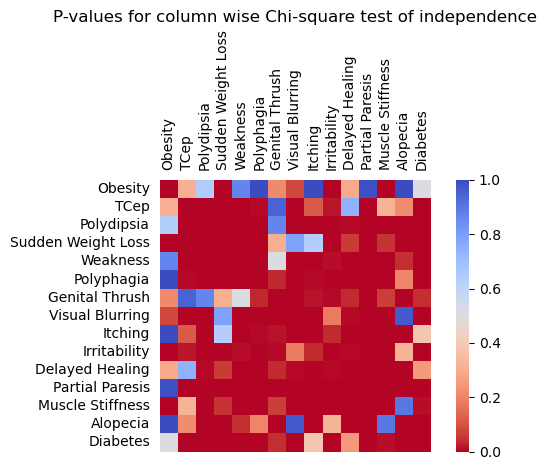

In [18]:
import matplotlib
from helpers import plot_chi_square_p_values

# reverse color as low p-value indicates strong dependence
plot_chi_square_p_values(train[binary_features + ['Diabetes']], kwargs={'cmap' : matplotlib.colormaps[cmap +'_r']})


Common sense can replace domain experts, in some cases - Roxana Pop, i.e. we should not use 'TCep' for our analysis (even though delayed healing might be correlated with aversion for tattoos)


## Data exploration

In [19]:
# There are some interesting things to see in the categoricals ...
# Only one Black in entire data set ...
# This looks very much like a rich person data set ...
for c in cat_features:
  print(train.groupby(c, dropna=False).size())

#print(train['GP'].unique())

Race
Asian        5
Black        1
MISSING      9
White      401
dtype: int64
Occupation
Architect        30
Consultant       32
Dentist          26
Economist        32
Engineer         24
Entrepreneur     23
Journalist       22
Judge            36
Lawyer           22
MISSING           8
Manager          43
Retired         118
dtype: int64
GP
Dr. Albie Colon          29
Dr. Alice Watson         23
Dr. Andreea Gregory      25
Dr. Angharad Grainger    16
Dr. Arda O'Brien         20
Dr. Cristiano Ayala      11
Dr. Dominic Farmer       21
Dr. Ingrid Mata          16
Dr. Jamil Walters        16
Dr. Joshua Riley         24
Dr. Kameron Lancaster    26
Dr. Kason Lloyd          16
Dr. Khalid Sellers       18
Dr. Korey Clay           23
Dr. Lina Beech           19
Dr. Lorelai York         21
Dr. Madison Guy          28
Dr. Mayson Harris        20
Dr. Nial Higgs           18
Dr. Orla Arellano        21
MISSING                   5
dtype: int64


Polydipsia
0.0    1.946209
1.0    2.682977
Name: Urination, dtype: float64


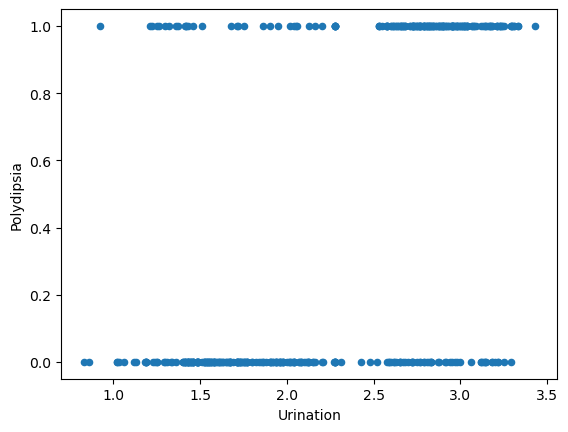

In [20]:
train.plot.scatter('Urination', 'Polydipsia')
print(train.groupby('Polydipsia')['Urination'].mean())

<Axes: ylabel='Frequency'>

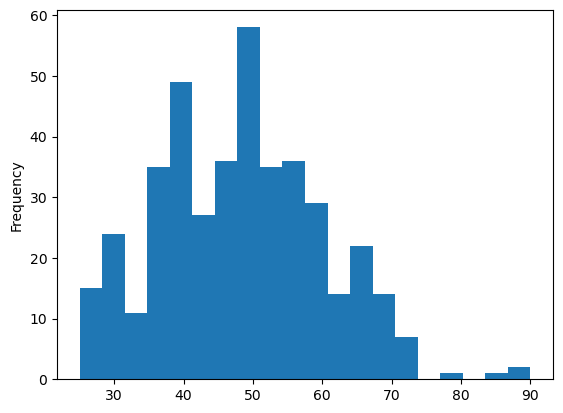

In [21]:
train['Age'].plot.hist(bins=20)

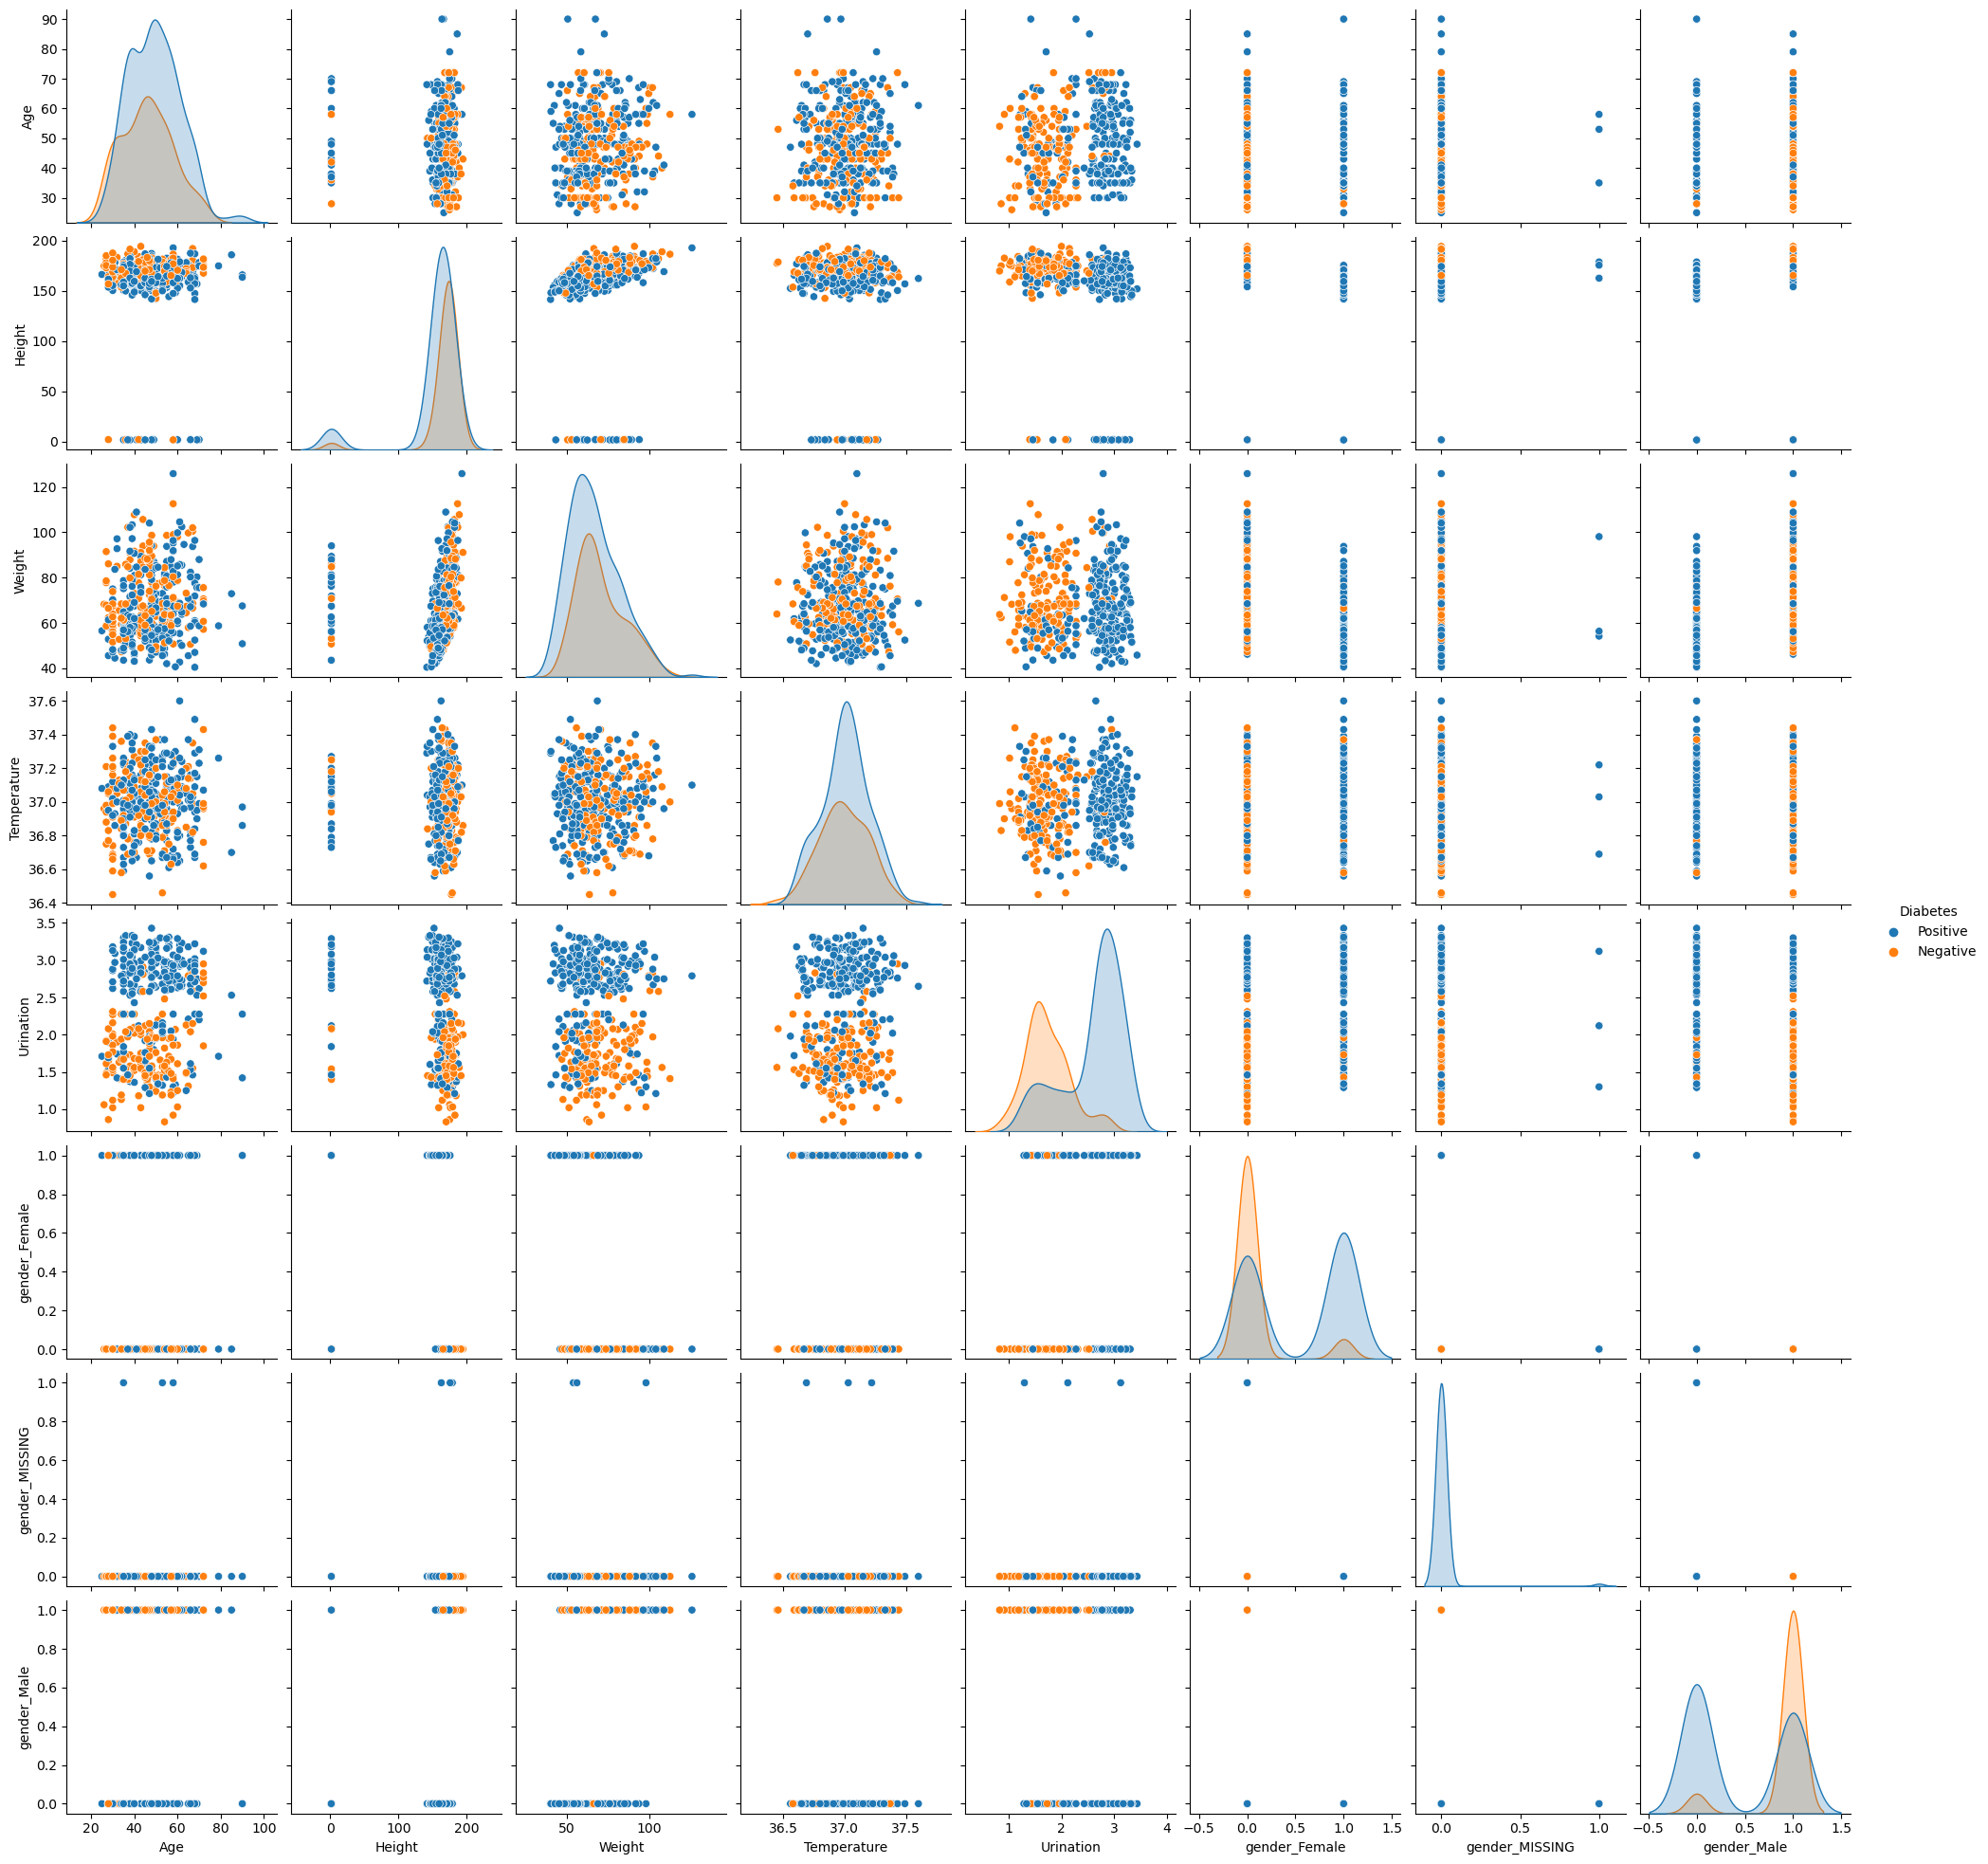

In [22]:
# After encoding, pair-plotting diabetes is messed up, because it tries to make 23*23 plots?
# need to drop the binaries from DF plotted.
train_plot = train.drop(binary_features , axis=1)

#diabetes_plot = train.drop('Gender', axis=1)
g = sns.pairplot(train_plot, hue='Diabetes')

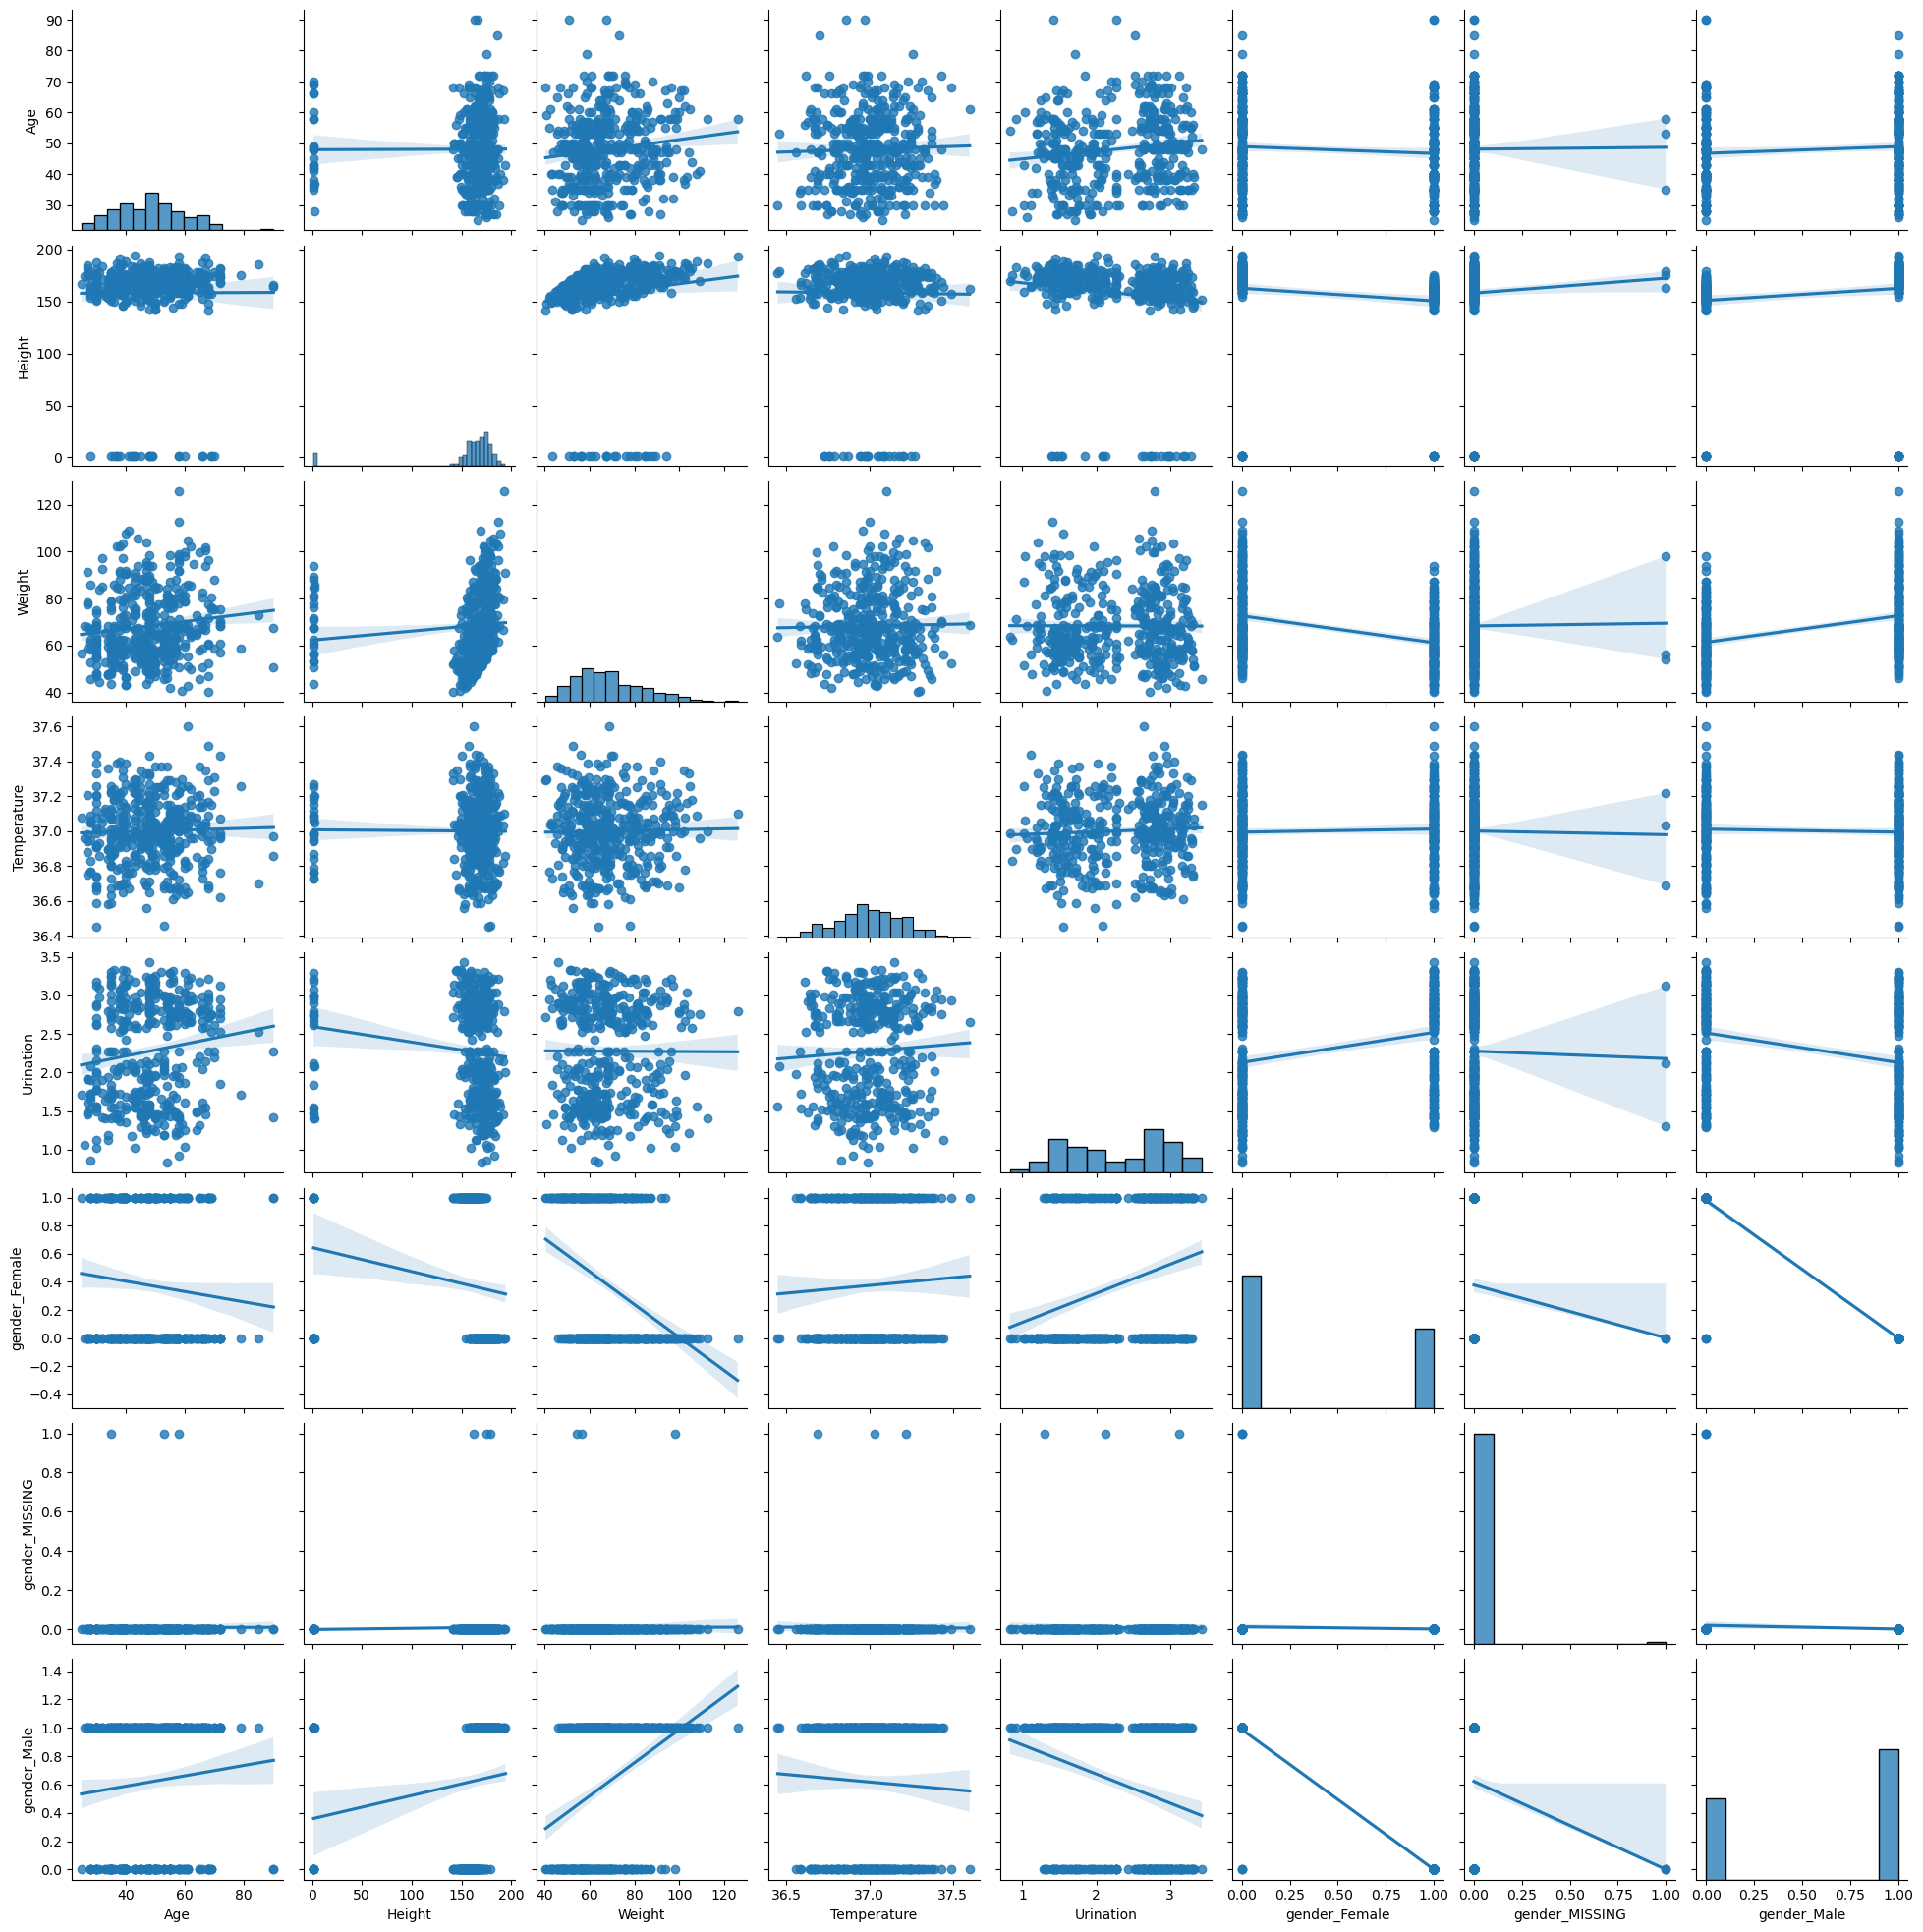

In [23]:
g = sns.pairplot(train_plot, kind='reg')

In [24]:
# Perhaps redundant given the chi-square plot earlier?
for f in binary_features:
  cross_tab = pd.crosstab(diabetes[f], diabetes['Diabetes'], rownames=[f], colnames=['Diabetes'])
  print(cross_tab)
  print('-----------------------')

Diabetes  Negative  Positive
Obesity                     
0.0            171       264
1.0             25        53
-----------------------
Diabetes  Negative  Positive
TCep                        
0               54       243
1              146        77
-----------------------
Diabetes    Negative  Positive
Polydipsia                    
0.0              190        94
1.0                8       222
-----------------------
Diabetes            Negative  Positive
Sudden Weight Loss                    
0.0                      169       127
1.0                       29       181
-----------------------
Diabetes  Negative  Positive
Weakness                    
0.0            110       100
1.0             87       218
-----------------------
Diabetes    Negative  Positive
Polyphagia                    
0.0              151       131
1.0               48       188
-----------------------
Diabetes        Negative  Positive
Genital Thrush                    
0.0                  163       236

# Training model

In [25]:
one_hot_features['Gender']

['gender_Female', 'gender_MISSING', 'gender_Male']

In [26]:
# Some sanity checks
assert train.isna().sum().sum() == 0, 'No Na-s should be present after handling. They must have been introduced'

#selected_features = ['Urination', 'Age'] + binary_features
selected_features = num_features + binary_features + one_hot_features['Gender'] 
print(selected_features)
print(len(selected_features))

# This is so stupid ... Never mind, Decision tree does not seem to care if X is series or DF ...
# Naive Bayes does, I think ...
#if len(selected_features) == 1:
#  X_train = train2[[selected_features[0]]]
#else:
X_train = train[selected_features]
y_train = train['Diabetes']

# Test set
X_test = test[selected_features]
y_test = test['Diabetes']


for index in X_train.dtypes.keys():
    dtype = X_train.dtypes[index]
    print(index, dtype)
    # Quite ugly and not very felxible test. Should be improved upon
    assert dtype == 'float64' or dtype == 'int64' or dtype == 'uint8', f"feature '{index}' is not of type float or int but {dtype}"


['Age', 'Height', 'Weight', 'Temperature', 'Urination', 'Obesity', 'TCep', 'Polydipsia', 'Sudden Weight Loss', 'Weakness', 'Polyphagia', 'Genital Thrush', 'Visual Blurring', 'Itching', 'Irritability', 'Delayed Healing', 'Partial Paresis', 'Muscle Stiffness', 'Alopecia', 'gender_Female', 'gender_MISSING', 'gender_Male']
22
Age float64
Height float64
Weight float64
Temperature float64
Urination float64
Obesity float64
TCep int64
Polydipsia float64
Sudden Weight Loss float64
Weakness float64
Polyphagia float64
Genital Thrush float64
Visual Blurring float64
Itching float64
Irritability float64
Delayed Healing float64
Partial Paresis float64
Muscle Stiffness float64
Alopecia float64
gender_Female uint8
gender_MISSING uint8
gender_Male uint8


Age : 21.2518827745887
Height : 134.97690258266644
Weight : 22.413027319690322
Temperature : 0.0008135675786149199
Urination : 32.63502272657772
Obesity : 0.5501586367055897
TCep : 51.43286221671818
Polydipsia : 95.3798133077573
Sudden Weight Loss : 40.48670454917143
Weakness : 11.780001962515946
Polyphagia : 25.636651594751868
Genital Thrush : 3.6963227081838
Visual Blurring : 17.16239819448533
Itching : 0.501093579634066
Irritability : 26.492410950838966
Delayed Healing : 0.875085860072613
Partial Paresis : 40.47632821799286
Muscle Stiffness : 4.517185515051771
Alopecia : 16.036548488750363
gender_Female : 55.72145357014359
gender_MISSING : 1.837209302325581
gender_Male : 35.54796041521341


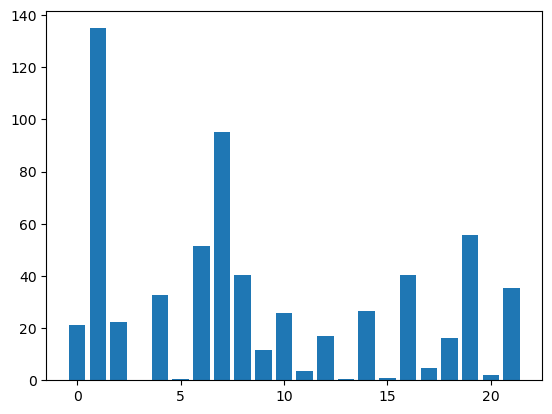

,Age,Height,Weight,Urination,TCep,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Visual Blurring,Irritability,Partial Paresis,Alopecia,gender_Female,gender_Male
124,68.0,147.35,60.93,3.02,0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1,0
387,33.0,155.50,65.46,1.41,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
270,30.0,161.55,57.91,2.01,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
305,53.0,162.43,54.79,2.98,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1
15,28.0,160.01,45.50,1.72,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,55.0,174.21,68.45,2.77,1,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0,1
2,51.0,164.19,57.02,1.34,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,0
97,35.0,154.89,56.83,3.17,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0
290,48.0,159.30,54.45,2.77,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1,0


In [27]:
from sklearn.feature_selection import SelectKBest, chi2
skb =  SelectKBest(chi2, k=15)
X_new = skb.fit_transform(X_train, y_train)

cols_idxs = skb.get_support(indices=True)
features_df_new = X_train.iloc[:,cols_idxs]



# what are scores for the features
for i in range(len(skb.scores_)):
 print(X_train.columns[i], ":", skb.scores_[i])
# plot the scores
plt.bar([i for i in range(len(skb.scores_))], skb.scores_)
plt.show()
features_df_new

Decision tree with depth=1. cv score: 0.7789156626506024
Decision tree with depth=2. cv score: 0.8558519793459552
Decision tree with depth=3. cv score: 0.8823006310958117
Decision tree with depth=4. cv score: 0.8943488238668962
Decision tree with depth=5. cv score: 0.8918531267928858
Decision tree with depth=6. cv score: 0.8894148020654045
Decision tree with depth=7. cv score: 0.8943488238668961
Decision tree with depth=8. cv score: 0.9111589213998853
Decision tree with depth=9. cv score: 0.8822432587492829
Decision tree with depth=10. cv score: 0.9015203671830176
Decision tree with depth=11. cv score: 0.8942914515203672
Decision tree with depth=12. cv score: 0.8894721744119334
Decision tree with depth=13. cv score: 0.8942627653471027
Decision tree with depth=14. cv score: 0.8870625358577164
Decision tree with depth=15. cv score: 0.9039300057372348
Decision tree with depth=16. cv score: 0.8870338496844521
Decision tree with depth=17. cv score: 0.8967297762478484
Decision tree with dept

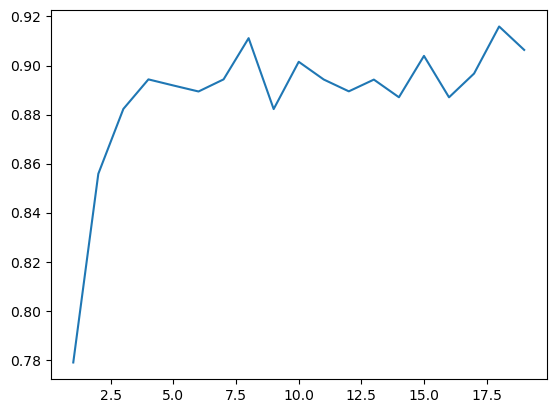

In [28]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

depths = list(range(1, 20))

scores = {}

"""
By weighing misslcassification more severly, we can minimze type II error,
which is desirable in the public health scenario. However, even with
a very skewed weighing (1-100), we still get missclassification,
indicatting that there are 'outliers' in the test set.

Further investigation revealed that they typically where quite old or quite young,
with a typical amount of urination.
"""
weight = {0: 1,
          1:1}

use_weights = False

for d in depths:
    clf_cv = tree.DecisionTreeClassifier(max_depth=d, class_weight=weight if use_weights else None)
    score = cross_val_score(clf_cv, X_train, y_train, cv=5).mean()
    scores[d] = score
    print(f'Decision tree with depth={d}. cv score: {score}')

print(scores.values())

plt.plot(scores.keys(), scores.values())

clf = tree.DecisionTreeClassifier(max_depth=7, class_weight=weight if use_weights else None)
clf = clf.fit(X_train, y_train)

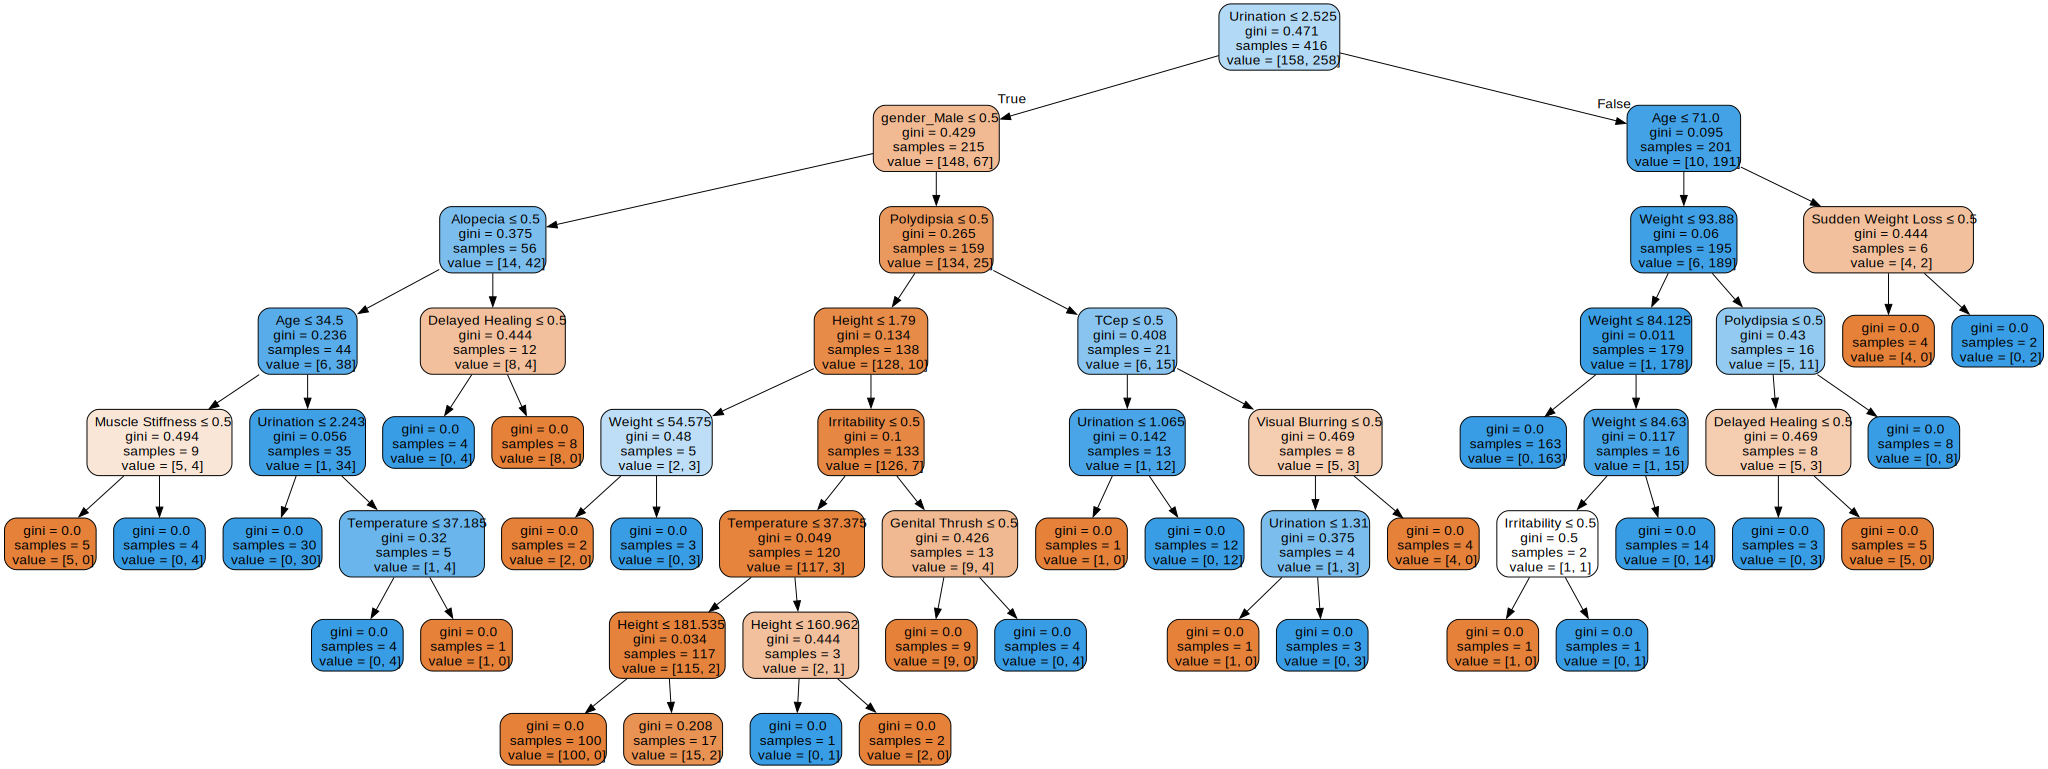

In [29]:
import graphviz

dot_data = tree.export_graphviz(clf, out_file=None,
                      feature_names=selected_features,
                      #class_names='Diabetes', # this parameter doesen't seem to work
                      filled=True, rounded=True,
                      special_characters=True)
graph = graphviz.Source(dot_data)
# Make Pdf
#graph.render("Diabetes")
graph

In [30]:
# Training accuracy
from sklearn import metrics
y_train_pred = clf.predict(X_train)
metrics.accuracy_score(y_train, y_train_pred)

0.9951923076923077

In [31]:
y_test_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_test_pred)

0.9423076923076923

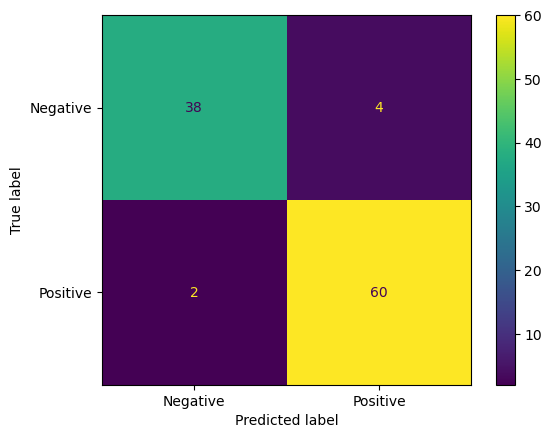

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

confusion_mat = metrics.confusion_matrix(y_test, y_test_pred)
con_mat_disp = ConfusionMatrixDisplay(confusion_mat, display_labels=clf.classes_)
con_mat_disp.plot()

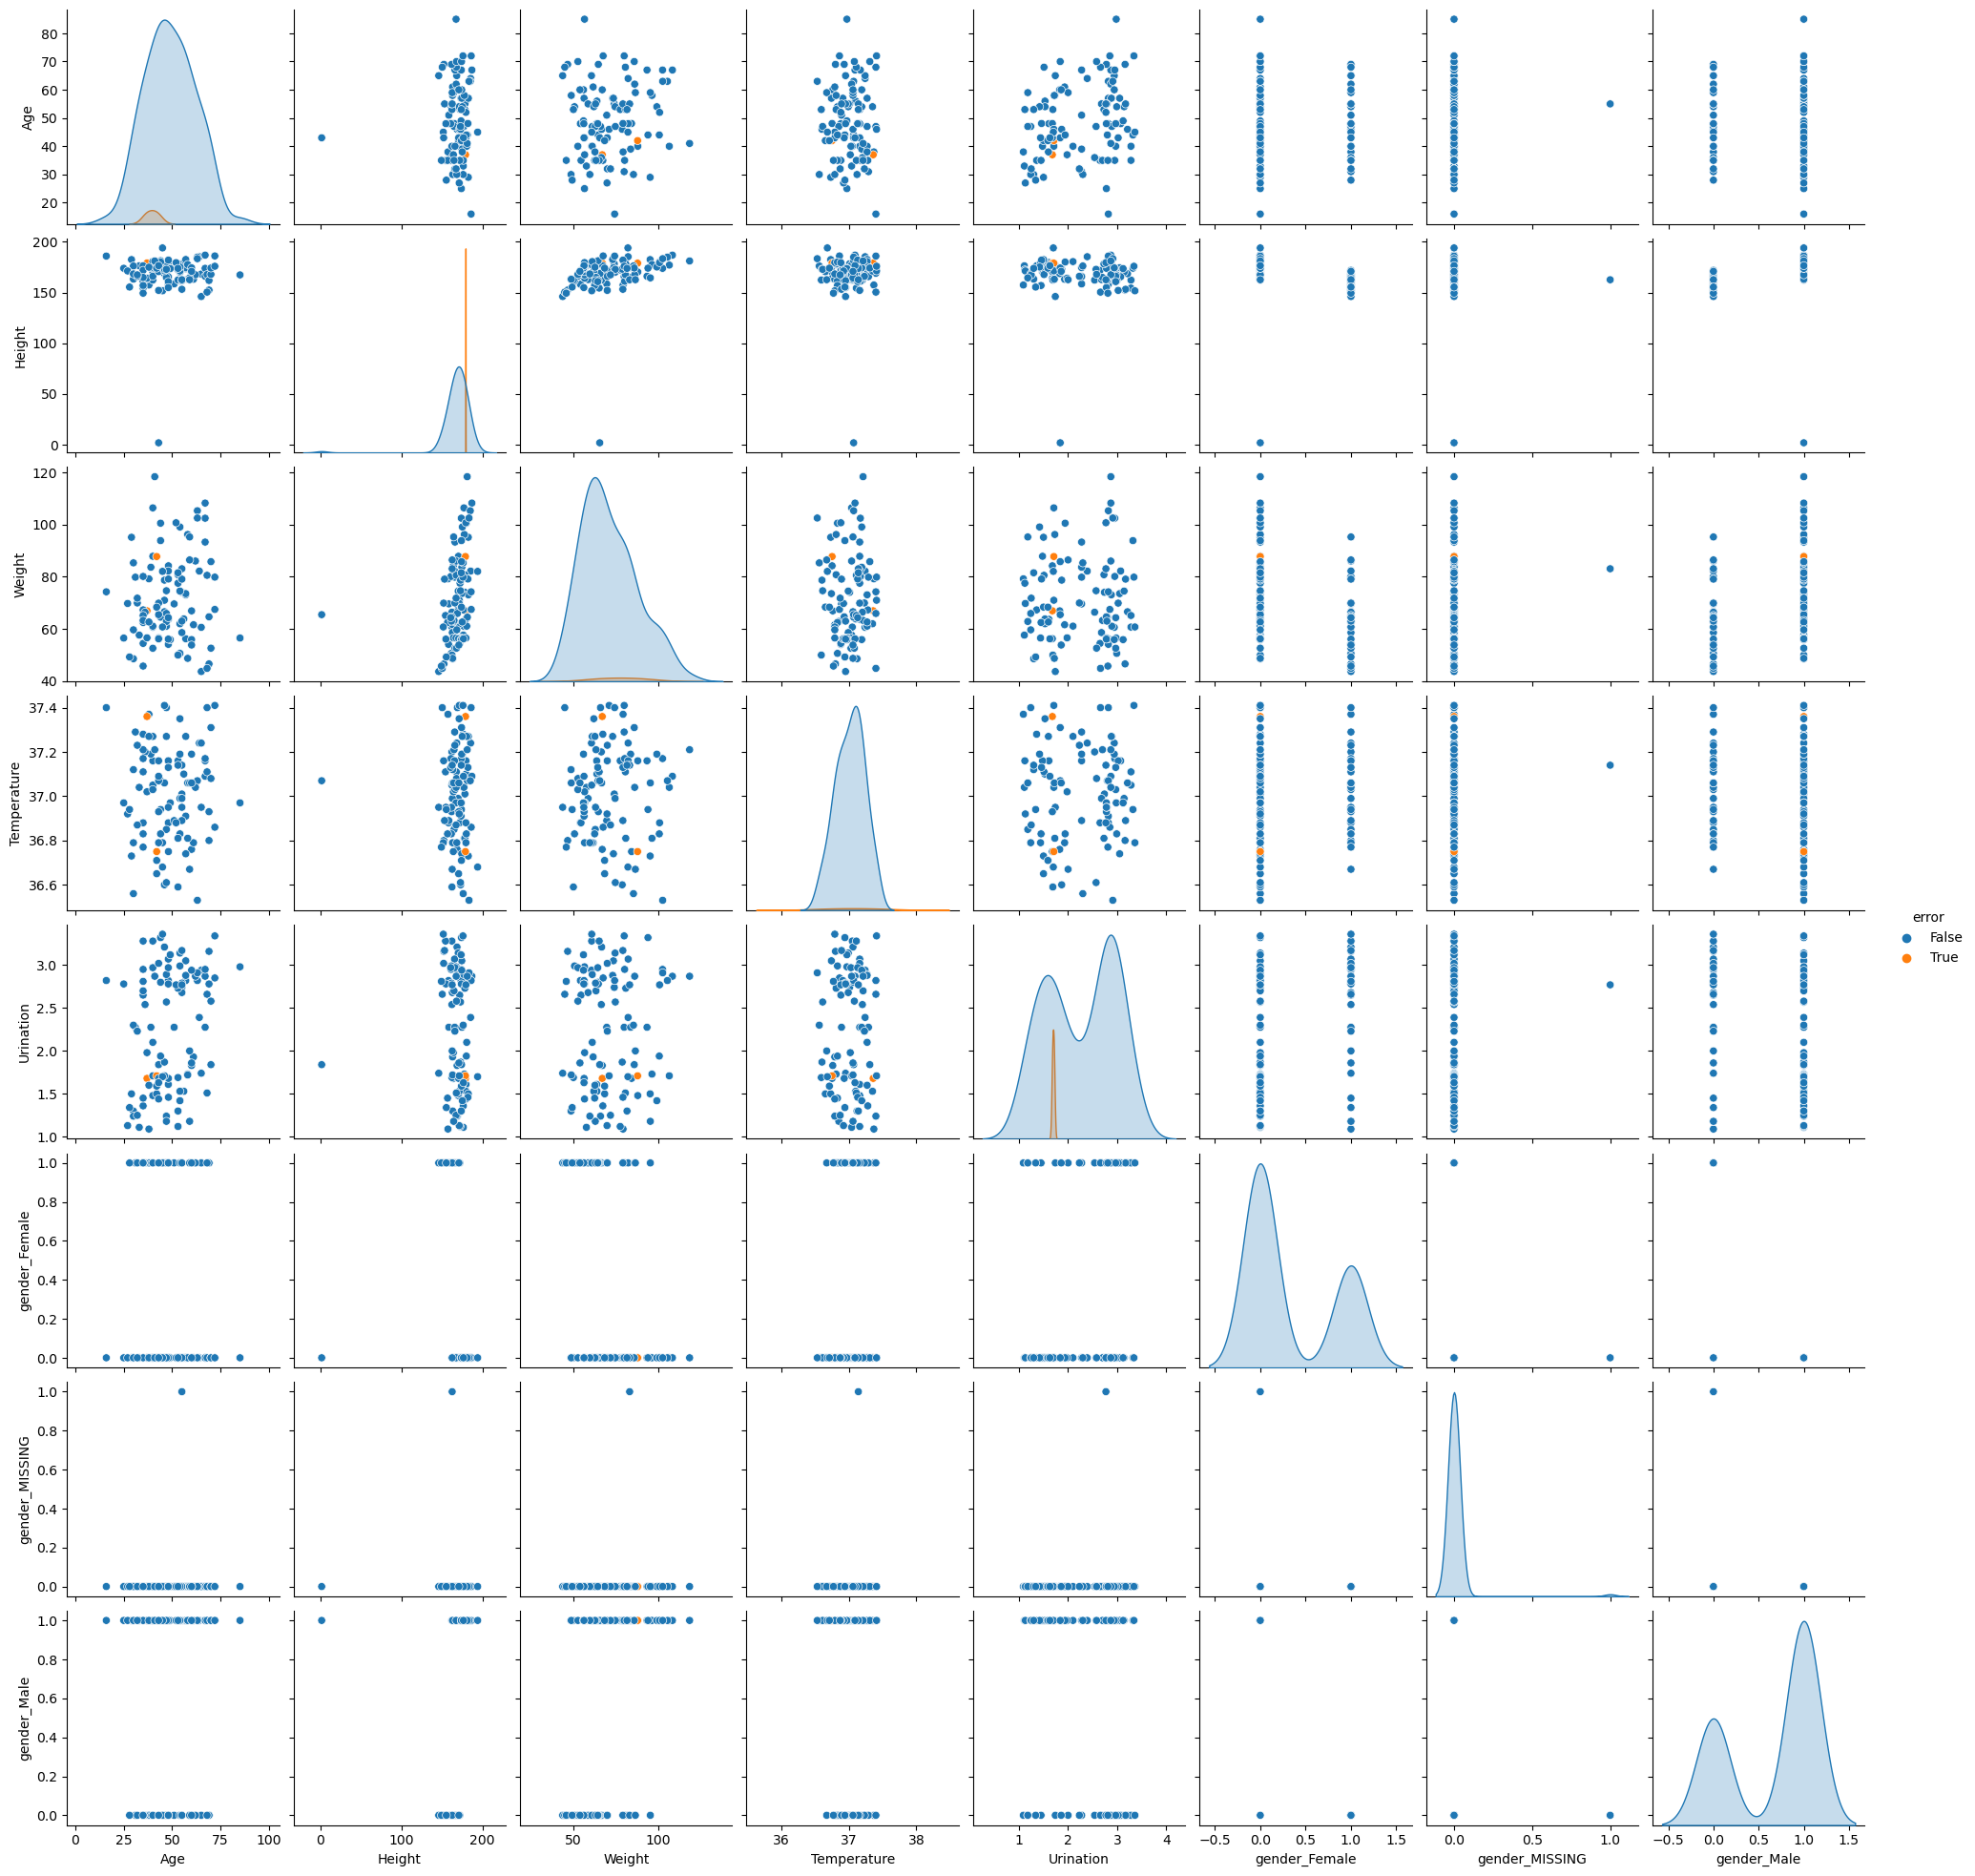

In [33]:
X_test_plot = X_test.copy()
X_test_plot['error'] = y_test > y_test_pred
g = sns.pairplot(X_test_plot.drop(binary_features, axis=1), hue='error')

Logistic regression with C = 10.00. cv score: 0.9278542742398164
Logistic regression with C = 7.85. cv score: 0.9278542742398164
Logistic regression with C = 6.16. cv score: 0.9278542742398164
Logistic regression with C = 4.83. cv score: 0.9278542742398164
Logistic regression with C = 3.79. cv score: 0.925473321858864
Logistic regression with C = 2.98. cv score: 0.925473321858864
Logistic regression with C = 2.34. cv score: 0.9278829604130809
Logistic regression with C = 1.83. cv score: 0.9302925989672979
Logistic regression with C = 1.44. cv score: 0.9278829604130809
Logistic regression with C = 1.13. cv score: 0.9279116465863453
Logistic regression with C = 0.89. cv score: 0.9279116465863453
Logistic regression with C = 0.70. cv score: 0.9183017785427424
Logistic regression with C = 0.55. cv score: 0.9158921399885255
Logistic regression with C = 0.43. cv score: 0.9135111876075731
Logistic regression with C = 0.34. cv score: 0.9135111876075731
Logistic regression with C = 0.26. cv sco

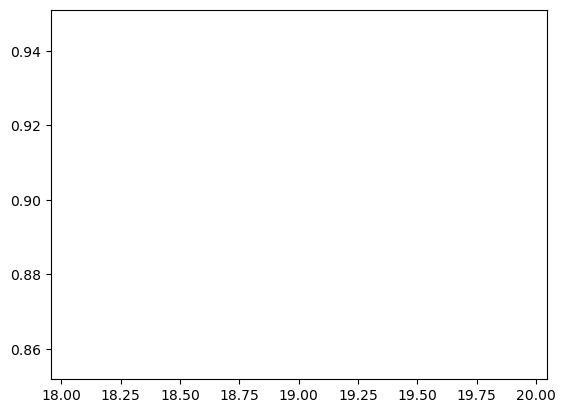

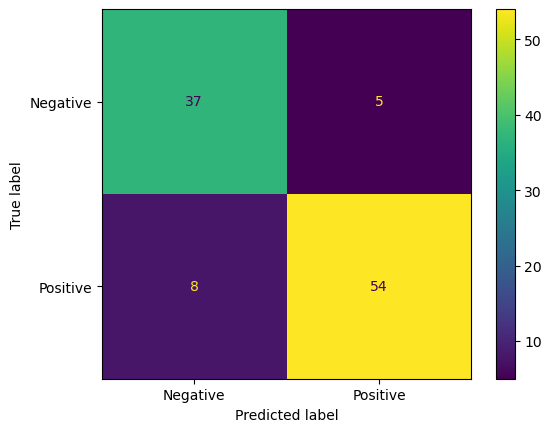

In [34]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1', solver='liblinear', C=1000)

cs = 1/np.geomspace(0.1, 10, 20)

scores = {}


for c in cs:
    clf_cv = LogisticRegression(penalty='l2', solver='liblinear', C=c)
    score = cross_val_score(clf_cv, X_train, y_train, cv=5).mean()
    scores[d] = score
    print(f'Logistic regression with C = {c:.2f}. cv score: {score}')

print(scores.values())

plt.plot(scores.keys(), scores.values())



clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)

# Accuracy
print(metrics.accuracy_score(y_test, y_test_pred))
print(clf.coef_)

# Confusion Matrix
confusion_mat = metrics.confusion_matrix(y_test, y_test_pred)
con_mat_disp = ConfusionMatrixDisplay(confusion_mat, display_labels=clf.classes_)
con_mat_disp.plot()


In [35]:
metrics.accuracy_score(y_test, y_test_pred)

0.875